In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [107]:
def remove_punct(df):
    """
    Removes semantically meaningless punctuation (components use : to denote hierarchy)
    Parameters:
        df (dataframe): dataframe containing text for cleaning
    Returns:
        dataframe
    """
    cols = df.columns
    for col in cols:
        try:
            if df[col].dtype == "O" and col != "COMPNAME":
                df.loc[:, col] = df[col].str.replace(r"[^\w\s]", "", regex=True)
        except AttributeError as e:
            print(f"Check for non-string datatypes: {e}")


def lowercase(df):
    """
    Converts text to lowercase.
    Parameters:
        df (dataframe): dataframe containing text for cleaning
    Returns:
        dataframe
    """
    cols = df.columns
    for col in cols:
        try:
            if df[col].dtype == "O":
                df.loc[:, col] = df[col].str.lower()
        except AttributeError as e:
            print(f"Check for non-string datatypes: {e}")


def convert_datetime(data, columns=None, format="%Y%m%d", errors="coerce"):
    """
    Converts given columns to datetime.
    Parameters:
        data (pandas.DataFrame): The DataFrame containing the data to be converted.
        columns (list | None): The list of column names to be converted to datetime (default is ["RCDATE", "DATEA"]).
        format (str, optional): The format string used to parse the datetime columns (default is "%Y%m%d").
        errors (str, optional): How to handle parsing errors. Options are "raise", "coerce",
          and "ignore" (default is "coerce", which converts parsing errors to NaT).

    Returns:
        None: The function modifies the input DataFrame in place
    """
    if columns is None:
        columns = ["RCDATE", "DATEA", "ODATE", "BGMAN", "ENDMAN"]
    for col in columns:
        data.loc[:, col] = pd.to_datetime(data[col], format=format, errors=errors)

# When the Customer Is Right: Analyzing Automotive Customer Complaint Data to Identify Serious Safety Issues

## Step 1
### Identify Components Most Implicated in Recalls

In [108]:
# Load recall data
recalls_headers = pd.read_csv("./data/RCL_headers.txt")
recalls_head = recalls_headers.values.tolist()
rcl_headers = [head for sublist in recalls_head for head in sublist]

recalls = pd.read_csv(
    "./data/FLAT_RCL.txt", sep="\t", names=rcl_headers, on_bad_lines="warn"
)

Skipping line 188394: expected 27 fields, saw 34

/var/folders/4x/y38ttwq12519_qtj737r25vh0000gn/T/ipykernel_70520/2183926908.py:6: DtypeWarning: Columns (17,18,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  recalls = pd.read_csv(


In [109]:
recalls.sample(2)

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,RPNO,FMVSS,DESC_DEFECT,CONEQUENCE_DEFECT,CORRECTIVE_ACTION,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
39089,39090,76V123000,REVCON,280,1975,NaN,"SERVICE BRAKES, HYDRAULIC:PEDALS AND LINKAGES","REVCON, INCORPORATED",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,REVCON CAMPAIGN NO N/A.MOTORHOMES.POSSIBILITY ...,000002286000051152000000063,NaN,NaN,NaN
221676,221680,22V365000,MERCEDES-BENZ,GLB250,2021,2022060005,COMMUNICATION: AUTO CRASH NOTIFICATION,"Mercedes-Benz USA, LLC",NaN,NaN,...,NaN,NaN,"Mercedes-Benz USA, LLC (MBUSA) is recalling ce...",A disabled eCall system would prevent a vehicl...,The communication module software will be upda...,Owners may also contact the National Highway T...,000120389004695767000001420,SW communication module,SW communication module,A2479026702


In [110]:
recalls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248841 entries, 0 to 248840
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   RECORD_ID          248841 non-null  int64  
 1   CAMPNO             248841 non-null  object 
 2   MAKETXT            248841 non-null  object 
 3   MODELTXT           248841 non-null  object 
 4   YEARTXT            248841 non-null  int64  
 5   MFGCAMPNO          150692 non-null  object 
 6   COMPNAME           248841 non-null  object 
 7   MFGNAME            248836 non-null  object 
 8   BGMAN              115289 non-null  float64
 9   ENDMAN             115533 non-null  float64
 10  RCLTYPECD          248841 non-null  object 
 11  POTAFF             248555 non-null  float64
 12  ODATE              236645 non-null  float64
 13  INFLUENCED_BY      248841 non-null  object 
 14  MFGTXT             248841 non-null  object 
 15  RCDATE             248841 non-null  int64  
 16  DA

In [111]:
# Basic data cleaning
lowercase(recalls)
remove_punct(recalls)
convert_datetime(recalls)
convert_datetime(recalls, columns=["YEARTXT"], format="%Y")
recalls.sample(10)

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,RPNO,FMVSS,DESC_DEFECT,CONEQUENCE_DEFECT,CORRECTIVE_ACTION,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
74888,74889,08c004000,combi,4400 travel systems,NaT,0208ctr01,child seat:base,combi usa inc,2005-10-19,2007-12-15,...,NaN,NaN,combi is recalling 67167 centre centre arb and...,should the seat separate from the base in a cr...,owners should contact combi to obtain a free r...,customers may contact the national highway tra...,000026156000364657000000359,NaN,NaN,NaN
98935,98936,13v407000,bmw,550i,2008-01-01,NaN,exterior lighting:tail lights,bmw of north america llc,2007-03-01,2009-12-31,...,NaN,NaN,bmw is recalling certain model year 2008 throu...,intermittent light operation reduces the abili...,bmw will notify owners and dealers will replac...,owners may also contact the national highway t...,000054692000355626000000223,NaN,NaN,NaN
79784,79785,08e050000,k2 motor,lhpcv01b,NaT,NaN,exterior lighting:headlights,k2 motor corporation,NaT,NaT,...,NaN,108,k2 motor is recalling 1921 aftermarket headlam...,without the amber side reflex reflectors the l...,k2 motor will notify owners and offer a full r...,this recall only pertains to aftermarket repla...,000027759000453840000000217,NaN,NaN,NaN
232205,232209,23v574000,mercedesbenz,e350,2023-01-01,2023080005,electrical system:adas,mercedesbenz usa llc,NaT,NaT,...,NaN,NaN,mercedesbenz usa llc mbusa is recalling certai...,failure to alert occupants of an approaching v...,dealers will update the exit warning system so...,owners may also contact the national highway t...,000125628005568940000001756,multimode radar software,multimode radar software,a0009020848
90879,90880,13v088000,terex,aerial devices,2012-01-01,sn605,equipment:electrical,terex south dakota inc,NaT,NaT,...,NaN,NaN,terex south dakota inc terex is recalling cert...,if the gfi does not function and a tool that i...,terex will notify owners and dealers will add ...,terexs recall campaign number is sn605owners m...,000054199001870810000000338,NaN,NaN,NaN
132209,132210,18v332000,jeep,cherokee,2015-01-01,u49u59u65u68u73,electrical system:software,chrysler fca us llc,2012-11-05,2017-12-17,...,NaN,NaN,chrysler fca us llc is recalling certain 20142...,if the vehicle maintains its speed or accelera...,chrysler will notify owners and dealers will i...,owners may also contact the national highway t...,000086207001977408000001105,NaN,NaN,NaN
233049,233053,22v831000,volkswagen,golf r,2016-01-01,91en,visibility/wiper,volkswagen group of america inc,NaT,NaT,...,NaN,NaN,volkswagen group of america inc volkswagen is ...,windshield wipers that cannot be activated may...,dealers will update the body control module so...,owners may also contact the national highway t...,000124231001996816000001349,software for body control module,software for body control module,sw level 0172
5325,5326,00v230003,mack,cl,1999-01-01,NaN,vehicle speed control:accelerator pedal,mack trucks incorporated,1999-02-01,2000-08-31,...,NaN,NaN,vehicle description class 8 trucks equipped w...,this condition could cause the pedal to go to ...,replacement accelerator pedals equipped with r...,owner notification began december 13 2000owner...,000011952000081052000000295,NaN,NaN,NaN
192897,192901,22v221000,prevost,x345 vip,2022-01-01,sr2205,electrical system:alternator/generator/regulator,prevost car us inc,NaT,NaT,...,NaN,NaN,prevost car us inc prevost is recalling certai...,an overheated alternator bearing can increase ...,prevost will replace the alternator belt free ...,owners may also contact the national highway t...,000119671004566740000000203,belt poly v 10pk1705,black rubber belt,506067
183908,183909,21v846000,tesla,model 3,2019-01-01,sb2100004,forward collision avoidance: warnings,tesla inc,NaT,NaT,...,NaN,NaN,tesla inc tesla is recalling certain 20172021 ...,unexpected activation of the aeb system may ca...,tesla service has released an overtheair ota s...,owners may al

In [112]:
recalls["ODATE"]

0        2003-02-10
1        2003-02-10
2        2002-09-23
3        2002-11-05
4        2002-11-05
            ...    
248836   2023-09-20
248837   2023-09-20
248838   2023-08-16
248839   2023-08-16
248840   2023-08-16
Name: ODATE, Length: 248841, dtype: datetime64[ns]

#### Recalls EDA

In [113]:
# Number of recall campaigns
print(f"Recall campaigns count: {len(recalls['CAMPNO'].unique())}")

# Number of unique components recalled
print(f"Number of unique components recalled: {len(recalls['RCL_CMPT_ID'].unique())}")

Recall campaigns count: 27436
Number of unique components recalled: 176081


In [114]:
# Check for variations in manufacturer name for companies of interest
# GM, Toyota, Tesla, Ford, Hyundai, Honda
gm = recalls.query('MFGNAME.str.contains("general motors", case=False, na=False)')
gm.loc[gm["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['general motors corp', 'general motors llc']

In [115]:
toyota = recalls.query('MFGNAME.str.contains("toyota", case=False, na=False)')
toyota.loc[toyota["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['toyota motor north america inc',
 'southeast toyota distributors',
 'gulf states toyota inc',
 'toyota motor co ltd',
 'toyota motor engineering  manufacturing',
 'southeast toyota distributors llc']

In [116]:
tesla = recalls.query('MFGNAME.str.contains("tesla", case=False, na=False)')
tesla.loc[tesla["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['tesla motors inc', 'tesla motors', 'tesla inc']

In [117]:
ford = recalls.query('MFGNAME.str.contains("ford", case=False, na=False)')
ford.loc[ford["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['ford motor company',
 'ford mtr cooverseas',
 'zf lemforder corporation',
 'ford motor company test adw as',
 'c  c ford']

In [118]:
hyundai = recalls.query('MFGNAME.str.contains("hyundai", case=False, na=False)')
hyundai.loc[hyundai["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['hyundai motor company',
 'hyundai caribbeanpuerto rico',
 'hyundai translead',
 'hyundai motor america',
 'hyundai truck america']

In [119]:
honda = recalls.query('MFGNAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['american honda motor co', 'honda american honda motor co', 'honda of minola']

In [120]:
# Standardize manufacturer names
recalls["MFGNAME"].replace(
    {
        "general motors llc": "general motors corp",
        "tesla motors inc": "tesla inc",
        "honda american honda motor co": "american honda motor co",
    },
    inplace=True,
)

In [121]:
# Check standardization
honda = recalls.query('MFGNAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['american honda motor co', 'honda of minola']

In [122]:
recalls_mfr_count = pd.DataFrame(recalls["MFGNAME"].value_counts(ascending=False))

print(
    f"Top 20 manufacturers most represented in recall data:\n{recalls_mfr_count[:20]}"
)

Top 20 manufacturers most represented in recall data:
                                         count
MFGNAME                                       
mercedesbenz usa llc                     41784
ford motor company                       12779
general motors corp                      10062
american honda motor co                   7044
daimler trucks north america llc          6932
paccar incorporated                       4920
forest river inc                          4637
nissan north america inc                  3593
bmw of north america llc                  3550
toyota motor engineering  manufacturing   3181
volkswagen group of america inc           3156
jaguar land rover north america llc       3015
chrysler corporation                      2804
chrysler fca us llc                       2670
blue bird body company                    2619
winnebago industries inc                  2306
navistar inc                              2276
prevost car us inc                        2270
daimle

In [123]:
recalls_mfr_count["percentage_of_recalls"] = recalls_mfr_count["count"] / len(recalls)
recalls_mfr_count.sort_values(by="percentage_of_recalls", ascending=False)[:20]

,count,percentage_of_recalls
MFGNAME,,
mercedesbenz usa llc,41784,0.167914
ford motor company,12779,0.051354
general motors corp,10062,0.040435
american honda motor co,7044,0.028307
daimler trucks north america llc,6932,0.027857
paccar incorporated,4920,0.019772
forest river inc,4637,0.018634
nissan north america inc,3593,0.014439
bmw of north america llc,3550,0.014266


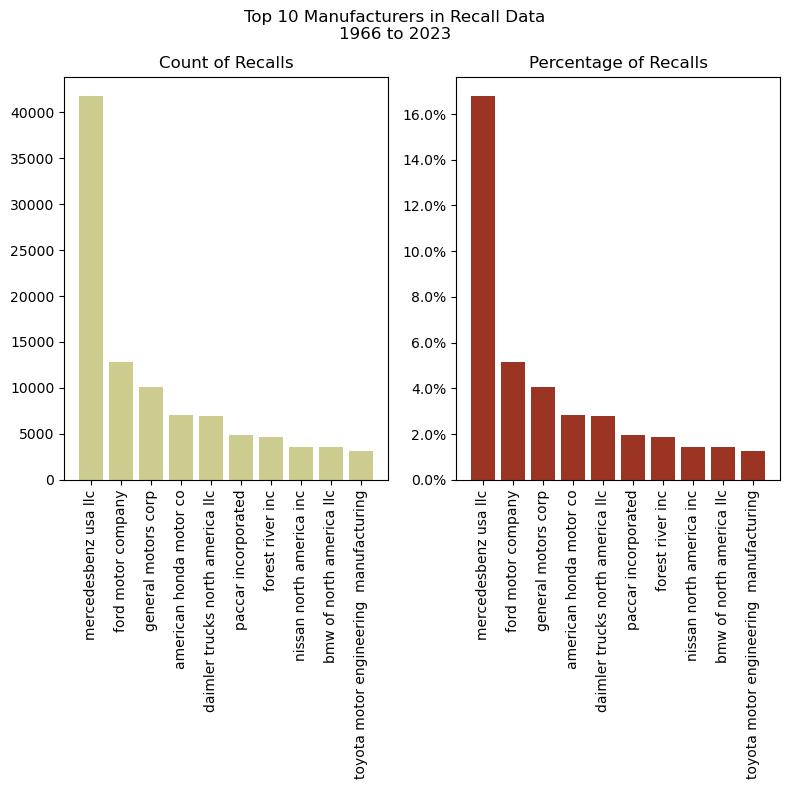

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.bar(recalls_mfr_count.reset_index()["MFGNAME"][:10], recalls_mfr_count["count"][:10], color="#cbcc8d")
ax1.set_xticks(recalls_mfr_count.reset_index()["MFGNAME"][:10])
ax1.set_xticklabels(recalls_mfr_count.reset_index()["MFGNAME"][:10], rotation=90)
ax1.set_title("Count of Recalls")

ax2.bar(recalls_mfr_count.reset_index()["MFGNAME"][:10], recalls_mfr_count["percentage_of_recalls"][:10], color="#9c3424")
ax2.set_xticks(recalls_mfr_count.reset_index()["MFGNAME"][:10])
ax2.set_xticklabels(recalls_mfr_count.reset_index()["MFGNAME"][:10], rotation=90)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.set_title("Percentage of Recalls")
plt.suptitle("Top 10 Manufacturers in Recall Data\n1966 to 2023")
plt.tight_layout()

In [125]:
# Get list of recall-prone components
rcl_common_compnames = pd.DataFrame(recalls["COMPNAME"].value_counts(ascending=False)[:50]).reset_index()
rcl_common_compnames.to_csv("./output/rcl_common_compnames.csv")
rcl_common_compnames

,COMPNAME,count
0,electrical system:software,18922
1,communication: auto crash notification,16630
2,equipment,11825
3,equipment:recreational vehicle/trailer,8015
4,equipment adaptive/mobility,5201
5,exterior lighting,4945
6,equipment:other:labels,4927
7,air bags:frontal:passenger side:inflator module,4440
8,electrical system,4364
9,"fuel system, gasoline:delivery:fuel pump",4111
